[0.0, 14.0, 7.0, 3.4999999999999996, 10.5, 2.25, 11.75, 5.25, 8.75, 0.0, 0.0, 0.0, 0.0, 0.0, -2.75, -2.75, -4.5, -4.5]
[0.0, 14.0, 7.0, 3.4999999999999996, 10.5, 2.25, 11.75, 5.25, 8.75, 0.0, 0.0, 0.0, 0.0, 0.0, -2.75, -2.75, -4.5, -4.5]
[7.0, 3.4999999999999996, 10.5, 2.25, 11.75, 5.25, 8.75, -2.75, -2.75, -4.5, -4.5]
[2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 17] [9, 12, 11, 13, 10, 0, 1]
[0.0, 14.0, 7.0, 3.4999999999999996, 10.5, 2.25, 11.75, 5.25, 8.75, 0.0, 0.0, 0.0, 0.0, 0.0, -2.75, -2.75, -4.5, -4.5]


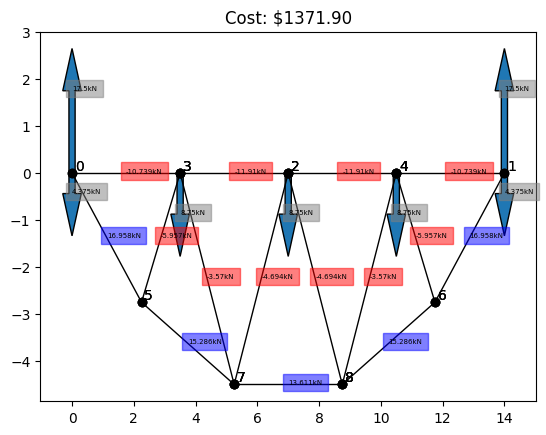

Initial Cost: 1371.9
[0, 1, 2, 3]
[nan nan nan nan nan nan nan nan nan nan nan]
[[nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]]


In [3]:
from truss_casadi import *
import numpy as np
import scipy as sp
from scipy.optimize import NonlinearConstraint, minimize, Bounds, shgo

truss, bridge_joints, xs = open_file("designs/final/truss_2000.json", y_shift=0, flip=False)

unknown_indices = list(np.arange(len(truss.joints)*2))
known_indices = []

for j in bridge_joints:
    # unknown_indices = np.delete(unknown_indices, j+len(truss.joints))
    unknown_indices.remove(j+len(truss.joints))
    known_indices.append(j+len(truss.joints))

# unknown_indices = np.delete(unknown_indices, bridge_joints[0])
unknown_indices.remove(bridge_joints[0])
unknown_indices.remove(bridge_joints[-1])
# unknown_indices = np.delete(unknown_indices, bridge_joints[-1])
known_indices.append(bridge_joints[0])
known_indices.append(bridge_joints[-1])

print(xs)
def correct(X):
    xs_ = xs.copy()
    for i in range(len(unknown_indices)):
        xs_[unknown_indices[i]] = X[i] 
    return xs_

unknowns = []
for i in unknown_indices:
    unknowns.append(xs[i])
print(unknowns)
print(unknown_indices, known_indices)
print(correct(unknowns))

cost = Function('cost', [truss.xs], [truss.cost])
real_cost = Function('real_cost', [truss.xs], [truss.real_cost])
cost_jac_ = Function('cost_jac', [truss.xs], [jacobian(truss.cost, truss.xs)])
[H, g] = hessian(truss.cost, truss.xs)
cost_hess_ = Function('cost_hess', [truss.xs], [H])

cost_jac = lambda x: np.array(cost_jac_(correct(x)))[...,unknown_indices].flatten()
cost_hess = lambda x: np.array(cost_hess_(correct(x)))[unknown_indices, :][:, unknown_indices]

truss.plot(xs, plot_member=True, plot_external=True)

print("Initial Cost:",real_cost(xs))

bridge_links = []
for i, link in enumerate(truss.links):
    if (link.i0 in bridge_joints and link.i1 in bridge_joints) and i not in bridge_links:
        bridge_links.append(i)

print(bridge_links)
print(cost_jac(xs))
print(cost_hess(xs))

In [4]:
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

nonlinear_constraints = []
for i, link in enumerate(truss.links):
    print(i, link.length)

print(len(truss.links))

for i in range(len(truss.links)):
    upper = np.inf
    if(i in bridge_links):
        upper = 3.5
    nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(Function('length{0}'.format(i),[truss.xs],[truss.links[i].length])(correct(x))), 1, upper))
    nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(Function('length{0}'.format(i),[truss.xs],[truss.links[i].force])(correct(x))), -6*3, 9*3))
for i in range(len(truss.joints)):
    if(truss.joints[i].type == JointType.PIN):
            nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(correct(x)[i]), 0, 0))
    if(truss.joints[i].type == JointType.ROLLER):
            nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(correct(x)[i]), 14, 14))

lower = [-14] * len(unknowns)
upper = [14] * len(unknowns)


bounds = tuple(zip(lower, upper))
print(xs)
print(bounds)

print(nonlinear_constraints)

res = minimize(lambda x: real_cost(correct(x)), unknowns, jac=cost_jac, hess=cost_hess, bounds=bounds, method='trust-constr',options={'initial_constr_penalty':1, 'maxiter':1000, 'verbose': 1}, constraints=[*nonlinear_constraints])

0 sqrt((sq((xs_0-xs_3))+sq((xs_9-xs_12))))
1 sqrt((sq((xs_3-xs_2))+sq((xs_12-xs_11))))
2 sqrt((sq((xs_2-xs_4))+sq((xs_11-xs_13))))
3 sqrt((sq((xs_4-xs_1))+sq((xs_13-xs_10))))
4 sqrt((sq((xs_0-xs_5))+sq((xs_9-xs_14))))
5 sqrt((sq((xs_6-xs_1))+sq((xs_15-xs_10))))
6 sqrt((sq((xs_4-xs_6))+sq((xs_13-xs_15))))
7 sqrt((sq((xs_5-xs_3))+sq((xs_14-xs_12))))
8 sqrt((sq((xs_5-xs_7))+sq((xs_14-xs_16))))
9 sqrt((sq((xs_7-xs_3))+sq((xs_16-xs_12))))
10 sqrt((sq((xs_7-xs_2))+sq((xs_16-xs_11))))
11 sqrt((sq((xs_2-xs_8))+sq((xs_11-xs_17))))
12 sqrt((sq((xs_8-xs_4))+sq((xs_17-xs_13))))
13 sqrt((sq((xs_8-xs_6))+sq((xs_17-xs_15))))
14 sqrt((sq((xs_8-xs_7))+sq((xs_17-xs_16))))
15
[0.0, 14.0, 7.0, 3.4999999999999996, 10.5, 2.25, 11.75, 5.25, 8.75, 0.0, 0.0, 0.0, 0.0, 0.0, -2.75, -2.75, -4.5, -4.5]
((-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14))
[<scipy.optimize._constraints.NonlinearConstraint object at 0x7febb06a3220>, <scipy.optimize.

/home/owen/anaconda3/lib/python3.10/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/owen/anaconda3/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 1000, CG iterations: 1182, optimality: 6.45e+00, constraint violation: 9.85e-02, execution time: 1.2e+02 s.


           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: 1342.750793326926
                 x: [ 7.159e+00  3.560e+00  1.074e+01  2.110e+00  1.204e+01
                      4.600e+00  9.690e+00 -2.417e+00 -2.240e+00 -4.248e+00
                     -4.097e+00]
               nit: 1000
              nfev: 1000
              njev: 559
              nhev: 559
          cg_niter: 1182
      cg_stop_cond: 2
              grad: [-1.620e+00  2.149e+01 -1.846e+01 -2.767e+00 -1.934e+00
                      6.002e+00 -3.590e+00 -4.917e+00 -1.791e-01  7.150e+00
                     -3.415e+00]
   lagrangian_grad: [ 2.539e-01  6.291e-01 -1.978e+00  6.451e+00 -5.311e-01
                      4.801e+00 -2.845e+00  5.104e+00 -3.466e-01  2.303e+00
                     -3.292e+00]
            constr: [array([ 3.560e+00]), array([-1.139e+01]), array([ 3.599e+00]), array([-1.194e+01]), array([ 3.577e+00]), array([-1.19

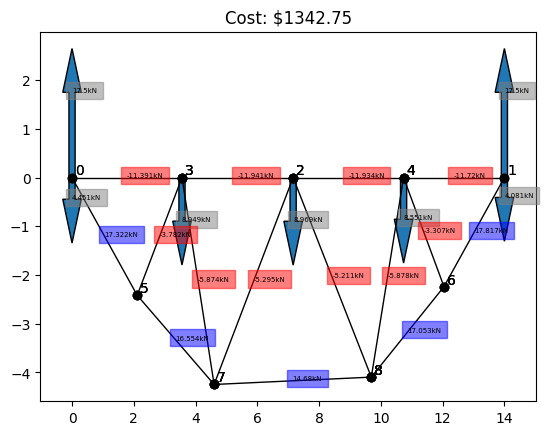

1342.75


In [5]:
x = correct(res.x)
print(res)
for link in truss.links:
    print(float(Function('length',[truss.xs],[link.length])(x)))

print(x)
truss.plot(x, plot_member=True, plot_external=True)

print(real_cost(x))

1458.85
